In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
import pickle
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


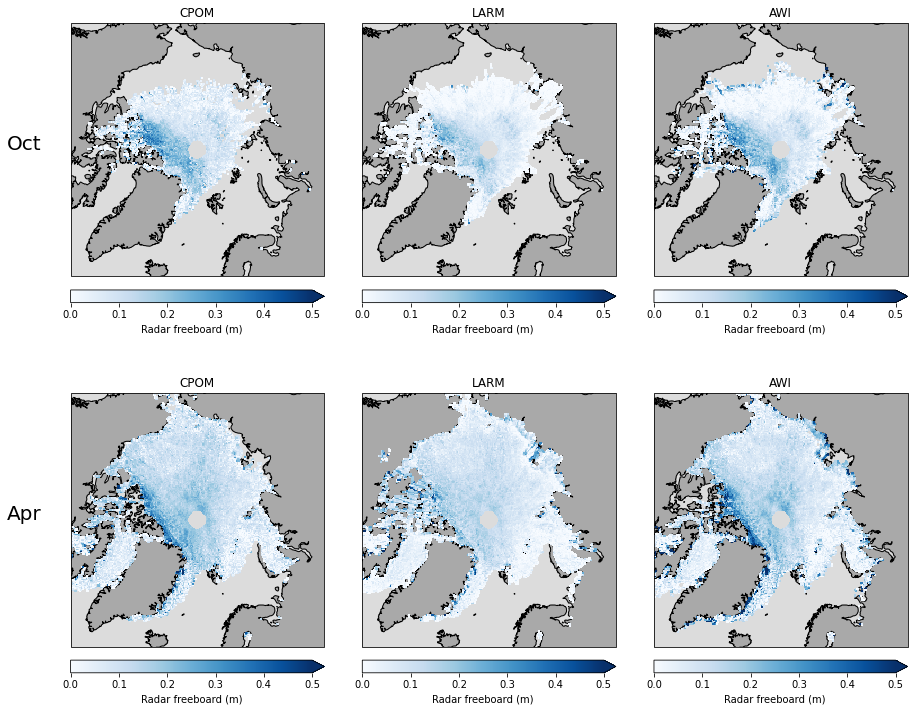

In [2]:
names = ['CPOM','LARM','AWI']
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')
datapath = '/Users/carmennab/Dropbox/met_office/data/freeboards/'
days = np.arange(0,212)
dates = [datetime.date(2016,10,1)+datetime.timedelta(days=np.int(days)) for days in days]

fig = plt.figure(figsize=(15,13))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0.15)

### October
days = np.arange(0,32)
for count, name in enumerate(names):
    f = open(datapath+name+'/dailyFB_25km_2016-2017_season.pkl','rb')
    data = pickle.load(f)
    f.close()
    
    fbs = np.full((len(days),360,360),np.nan)
    for c,day in enumerate(days):
        date = dates[day].strftime('%Y%m%d')
        fbs[c] = data[date]
    fb = np.nanmean(fbs,axis=0)
    
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.coastlines()
    ax.set_title(name)
    p_map = ax.pcolormesh(lons,lats,fb,cmap='Blues',vmin=0,vmax=0.5,transform=ccrs.PlateCarree()) 
    a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend = 'max') 
    a.set_label('Radar freeboard (m)',fontsize='medium')  
    
    if count == 0:
        ax.text(-0.25, 0.5, 'Oct', size=20, ha="left", transform=ax.transAxes)

### April
days = np.arange(182,212)
for count, name in enumerate(names):
    f = open(datapath+name+'/dailyFB_25km_2016-2017_season.pkl','rb')
    data = pickle.load(f)
    f.close()
    
    fbs = np.full((len(days),360,360),np.nan)
    for c,day in enumerate(days):
        date = dates[day].strftime('%Y%m%d')
        fbs[c] = data[date]
    fb = np.nanmean(fbs,axis=0)

    ax = fig.add_subplot(spec[3+count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.coastlines()
    ax.set_title(name)
    p_map = ax.pcolormesh(lons,lats,fb,cmap='Blues',vmin=0,vmax=0.5,transform=ccrs.PlateCarree()) 
    a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend = 'max') 
    a.set_label('Radar freeboard (m)',fontsize='medium')  

    if count == 0:
        ax.text(-0.25, 0.5, 'Apr', size=20, ha="left", transform=ax.transAxes)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/fb_maps.png',dpi=400, bbox_inches="tight")

### plot timeseries

In [10]:
days = np.arange(0,212)
mask = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','East Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

means = {}
sits = []

for name in names:
    f = open(datapath+name+'/dailyFB_25km_2016-2017_season.pkl','rb')
    data = pickle.load(f)
    f.close()
    data = np.array([data[key] for key in data])
    means[name] = np.array([np.nanmean(data[day]) for day in days])
    sits.append(data)
    print(data.shape)

#means['SM-LG'][np.isnan(means['FOAM'])] = np.nan
#means['AWI'][np.isnan(means['FOAM'])] = np.nan
    
for region, reg in zip(regions, regs):
    data = {}
    for name,sit in zip(names,sits):
        sit_c = sit.copy()
        for day in days:
            sit_c[day][~np.isin(mask,reg)] = np.nan
        data[name] = np.array([np.nanmean(sit_c[day]) for day in days])
        
  #  data['SM-LG'][np.isnan(data['FOAM'])] = np.nan
  #  data['AWI'][np.isnan(data['FOAM'])] = np.nan
        
    means[region] = data

(212, 360, 360)
(212, 360, 360)
(212, 360, 360)


Text(0.07, 0.45, 'Radar freeboard (m)')

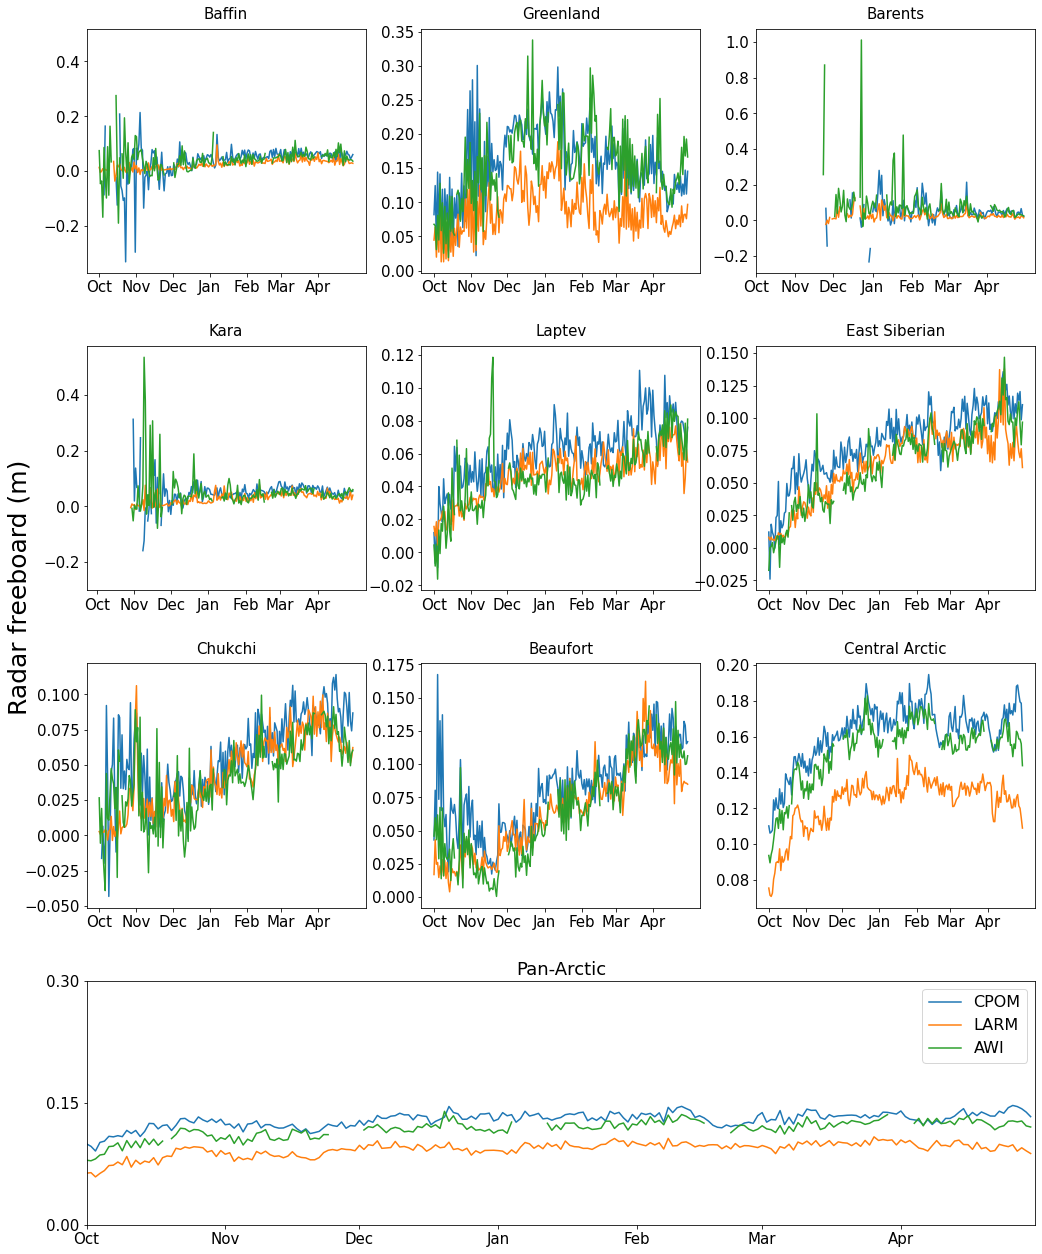

In [13]:
fig = plt.figure(figsize=(17,22))
spec = gridspec.GridSpec(ncols=3, nrows=4, wspace=0.2,hspace=0.3)
#ylims = [0.15,0.3,0.1,0.2,0.3,0.3,0.4,0.4,0.4]

for count,region in enumerate(regions):
    data = means[region]
    ax = fig.add_subplot(spec[count])
    ax.set_title(region,pad=10,fontsize=15)
    for name in names:
        ax.plot(days,data[name],label=name)
    ax.set_xticks([0,31,61,92,123,151,182])
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr'])
#    ax.set_ylim([0,ylims[count]])
    plt.rc('font', size=15)
 #   ax.set_yticks([0,ylims[count]/2,ylims[count]])
    
ax = fig.add_subplot(spec[9:12])
for name in names:
    ax.plot(days,means[name],label=name)
ax.set_ylim(0,0.3)
ax.set_xlim(0,212)
ax.set_title('Pan-Arctic')
ax.set_xticks([0,31,61,92,123,151,182])
ax.set_yticks([0,0.15,0.3])
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr'])  
ax.legend(loc='upper right',fontsize=16)

fig.text(0.07, 0.45, 'Radar freeboard (m)', ha='center',fontsize=25,rotation='vertical')
#plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/freeboard_regional_timeseries.png',dpi=400, bbox_inches="tight")